# Project 2 - Ames Housing Data and Kaggle Challenge
Author: _Ritchie Kwan_

---



## Table of Contents
1. [EDA and Data Cleaning](01-EDA-and-Cleaning.ipynb)
2. [Preprocessing and Feature Engineering](#preprocessing-and-feature-engineering)
3. [Modeling Benchmarks](03-Model-Benchmarks.ipynb)  
4. [Model Tuning](04-Model-Tuning.ipynb)  
5. [Production Model and Insights](05-Production-Model-and-Insights.ipynb)    
 

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

%matplotlib inline

### Load Data

Since we will train test split the training set, the actual test data will be read as `df_kaggle` to avoid confusion.

In [2]:
df_train = pd.read_csv('../datasets/train_clean.csv')
df_kaggle = pd.read_csv('../datasets/test_clean.csv')

<a id="preprocessing-and-feature-engineering"></a>
## Preprocessing and Feature Engineering

### Observe Correlations in a Heatmap

In [3]:
def corr_with_target(df, target = 'saleprice', n_features = 50, show = True) :
    '''
    Plots the correlation of all numeric columns with target.
    
    Returns the correlation with target
    '''
    # select only numerical columns
    df_numeric = df.select_dtypes(include = ['int', 'float', 'uint8'])

    # correlation matrix
    df_corr = df_numeric.corr()
    df_corr_with_target = df_corr[[target]].sort_values(target, ascending = False)

    if show:
        # Set the default matplotlib figure size to 12x12:
        fig, ax = plt.subplots(figsize=(5, df.shape[1]/50*15))

        plt.title('Correlation Heatmap with Sale Price', fontsize = 20)
        
        # Plot the heatmap with seaborn.
        # Assign the matplotlib axis the function returns. This will let us resize the labels.
        ax = sns.heatmap(df_corr_with_target, annot = True)

        # Resize the labels.
        ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
        ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

    plt.show();
    
    # index=0 is 'saleprice'
    return df_corr_with_target[1:n_features+1]
    

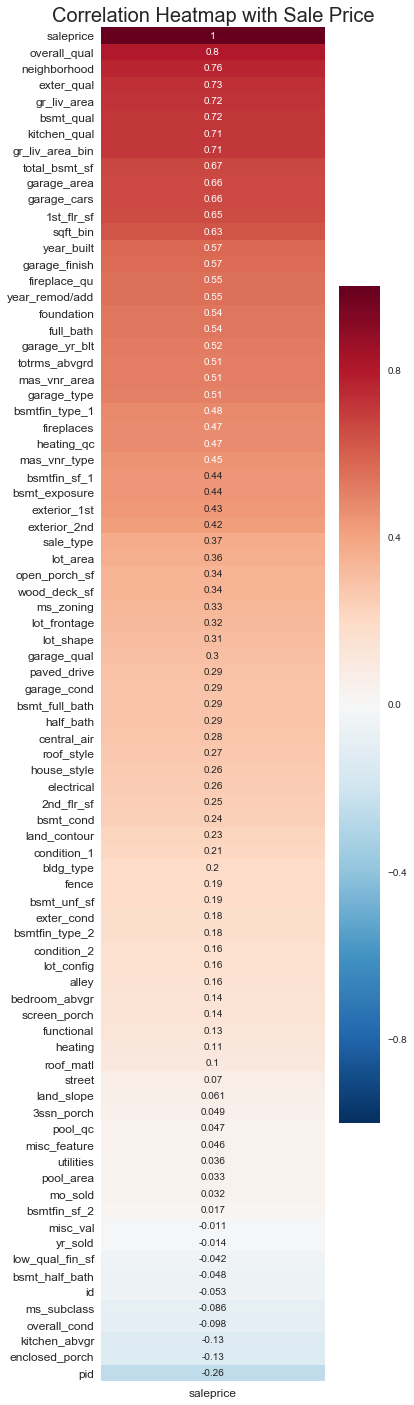

In [4]:
corr_with_y = corr_with_target(df_train, show = True)

### Choose features as predictors

Select the most correlated features as the predictors.

In [5]:
n_features = 30

features = corr_with_y[0:n_features].index.tolist()
features

['overall_qual',
 'neighborhood',
 'exter_qual',
 'gr_liv_area',
 'bsmt_qual',
 'kitchen_qual',
 'gr_liv_area_bin',
 'total_bsmt_sf',
 'garage_area',
 'garage_cars',
 '1st_flr_sf',
 'sqft_bin',
 'year_built',
 'garage_finish',
 'fireplace_qu',
 'year_remod/add',
 'foundation',
 'full_bath',
 'garage_yr_blt',
 'totrms_abvgrd',
 'mas_vnr_area',
 'garage_type',
 'bsmtfin_type_1',
 'fireplaces',
 'heating_qc',
 'mas_vnr_type',
 'bsmtfin_sf_1',
 'bsmt_exposure',
 'exterior_1st',
 'exterior_2nd']

### Select the most correlated features

Features selected were the most correlated original numerical features. Only a few categorical features that were converted to numerical were included as accurate predictors. Categorical features with few distinct values do not accurately predict unseen data.

In [6]:
features = [ 'neighborhood', 'overall_qual', 'exter_qual', 
             'gr_liv_area', 'bsmt_qual', 'kitchen_qual', 'total_bsmt_sf', 
             'garage_area', 'garage_cars', '1st_flr_sf', 
             'year_built', 'year_remod/add', 'full_bath', 
             'mas_vnr_area', 'totrms_abvgrd', 'garage_yr_blt', 
             'fireplaces', 'bsmtfin_sf_1', 'open_porch_sf', 
             'wood_deck_sf', 'lot_frontage', 'lot_area', 
             'bsmt_full_bath', 'half_bath']


### Define predictors and target

In [7]:
X = df_train[features]
y = df_train['saleprice']

X_kaggle = df_kaggle[features]

### Train Test Split

In [8]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = test_size, 
                                                    random_state = 42)

### Standardize X

In [9]:
ss = StandardScaler()

X_sc = pd.DataFrame(ss.fit_transform(X), columns = features)

X_train_sc = pd.DataFrame(ss.transform(X_train), columns = features)
X_test_sc = pd.DataFrame(ss.transform(X_test), columns = features)

X_kaggle_sc = pd.DataFrame(ss.transform(X_kaggle), columns = features)


### Interactive features

In [10]:
# instantiate poly
poly = PolynomialFeatures(include_bias = False)

# fit poly
poly = poly.fit(X_sc)

# get interactive column names
poly_features = poly.get_feature_names(X_sc.columns)

# transform X
X_poly_sc = pd.DataFrame(poly.transform(X_sc), columns = poly_features)

X_train_poly_sc = pd.DataFrame(poly.transform(X_train_sc), columns = poly_features)
X_test_poly_sc = pd.DataFrame(poly.transform(X_test_sc), columns = poly_features)

X_kaggle_poly_sc = pd.DataFrame(poly.transform(X_kaggle_sc), columns = poly_features)


### Save Processed Data

Since we have selected our predictors, we only need to save those columns, `id` of the Kaggle test set and `saleprice` of the training set for the next step.

In [11]:
# Recombine X and y
X_poly_sc['saleprice'] = y
X_train_poly_sc['saleprice'] = y_train.reset_index(drop=True)
X_test_poly_sc['saleprice'] = y_test.reset_index(drop=True)

# Need id column for predictions output
X_kaggle_poly_sc['id'] = df_kaggle['id']


In [12]:
X_poly_sc.to_csv('../datasets/train_processed.csv', index = False)
X_train_poly_sc.to_csv('../datasets/train_split_processed.csv', index = False)
X_test_poly_sc.to_csv('../datasets/test_split_processed.csv', index = False)
X_kaggle_poly_sc.to_csv('../datasets/kaggle_processed.csv', index = False)
